# Astrobrowser - Spitzer Photometry and Accurate Rotation Curves (SPARC)

Retrieve flux-calibrated photometric images in SDSS $g$, $r$, and $i$ bands (based on Giordano et al. zero points) and derive surface brightness profiles.

# 1. Initialisation

External libraries

In [1]:
#%matplotlib ipympl
import os
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator
from matplotlib.backends.backend_pdf import PdfPages
from astropy.coordinates import SkyCoord, get_icrs_coordinates
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import QTable
from astropy import units as u
from astropy import constants as c
from photutils.aperture import EllipticalAperture
from scripts import astrobrowser

In [2]:
%load_ext autoreload
%autoreload 2

Utility functions

In [3]:
def new_figure(fig_name, figsize=(12, 8), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}, suptitle=True):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize, layout="constrained")
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    #fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    if suptitle is True:
        fig.suptitle(fig_name)
    elif suptitle is not False and suptitle is not None:
        fig.suptitle(suptitle)
    
    return fig, axes

In [4]:
def draw_ellipse(ax, x0, y0, a, b, pa):
    theta = np.linspace(0, 2*np.pi, 361)
    along_major_axis = a*np.cos(theta)
    along_minor_axis = b*np.sin(theta)
    ra = x0 + along_major_axis * np.cos(pa + np.pi/2) + along_minor_axis *np.cos(pa + np.pi)
    dec = y0 + along_major_axis * np.sin(pa + np.pi/2) + along_minor_axis *np.sin(pa + np.pi)
    ax.plot(ra, dec, 'k--')

In [5]:
def test_dir(dir_name):
    if not os.path.isdir(dir_name):
        print(f'>> WARNING: Creating directory "{dir_name}"')
        os.makedirs(dir_name)
    return(dir_name)

Directories

In [6]:
input_dir = 'SPARC'
output_dir = test_dir(os.path.join(input_dir, 'output'))
maps_dir = test_dir(os.path.join(output_dir, 'maps'))
plots_dir = test_dir(os.path.join(output_dir, 'plots'))

# 2. Observations

## SPARC catalogue
I had to edit the file a bit to conform to the Machine Readable Table (MRT) format

In [7]:
SPARC_catalogue = QTable.read(os.path.join(input_dir, 'SPARC_clean.mrt'), format='mrt')

In [8]:
SPARC_catalogue

Galaxy,T,D,e_D,f_D,Inc,e_Inc,L[3.6],e_L[3.6],Reff,SBeff,Rdisk,SBdisk,MHI,RHI,Vflat,e_Vflat,Q,Ref.
,,Mpc,Mpc,,deg,deg,1e+09 Lsun,1e+09 Lsun,kpc,Lsun / pc2,kpc,Lsun / pc2,1e+09 Msun,kpc,km / s,km / s,,
str7,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str4
NGC6195,3,127.8,12.8,1,62.0,5.0,391.076,6.123,9.52,686.8,13.94,174.11,20.907,40.89,251.7,9.3,1,SG06


## SDSS HiPS skymaps

In [9]:
class HiPS_skymap(object):
    
    def __init__(self, hips_service_url, units, beam=None):
        '''Intensity map in Hierarchical Progressive Survey (HiPS) format'''
        
        print(f'> {hips_service_url}')
        self.url = hips_service_url
        self.properties = astrobrowser.get_hips_proprties(hips_service_url)
        if self.properties is None:
            print('  ERROR: HiPS properties not available!')
            raise -1
        if 'hips_pixel_scale' in self.properties:
            self.hips_pixel = float(self.properties['hips_pixel_scale']) * u.deg
        else:
            print('  ERROR: HiPS pixel size not available!')
            raise -1

        if beam is None:
            if 's_pixel_scale' in self.properties:
                original_pixel = float(self.properties['s_pixel_scale']) * u.deg
                self.beam = original_pixel**2
            else:
                self.beam = self.hips_pixel**2
                print(f'  WARNING: original pixel size not available! using HiPS size = {self.hips_pixel.to_value(u.arcsec)} arcsec')
        else:
            self.beam = beam
            original_pixel_beam = np.sqrt(beam)
            if 's_pixel_scale' in self.properties:
                original_pixel_properties = float(self.properties['s_pixel_scale']) * u.deg
                if not u.isclose(original_pixel_beam, original_pixel_properties):
                    print(f'  WARNING: {original_pixel_beam} is different from {original_pixel_properties} ({original_pixel_properties.to(original_pixel_beam.unit)})')

        self.intensity_units = units
        if u.get_physical_type(units) == 'spectral flux density':
            self.intensity_units = units / self.beam
        
        print(f'  HiPS pixel = {self.hips_pixel.to(u.arcsec):.4f}, original = {np.sqrt(self.beam).to(u.arcsec):.4f}',
              f'; units = {self.intensity_units.to(u.uJy/u.arcsec**2):.2f} = {self.intensity_units.to(u.MJy/u.sr):.4f}')


These SDSS measurements correpond to surface brightness in nanomaggies per beam (original pixel)

In [10]:
nanomaggies = 3.631e-6*u.Jy
beam = (0.39564 * u.arcsec)**2
pivot_wavelength = {
    'g': 4702.50 * u.Angstrom,
    'r': 6175.58 * u.Angstrom,
    'i': 7489.98 * u.Angstrom,
}
solar_units_factor = (4*np.pi*u.sr) * c.c  # divide by the pilot wavelength to convert from intensity (e.g. nanomaggies/beam) to luminosity surface brightness (Lsun/pc^2)

In [11]:
SDSS_skymaps = {
    'g': HiPS_skymap('https://alasky.cds.unistra.fr/SDSS/DR9/band-g', nanomaggies, beam),
    'r': HiPS_skymap('https://alasky.cds.unistra.fr/SDSS/DR9/band-r', nanomaggies, beam),
    'i': HiPS_skymap('https://alasky.cds.unistra.fr/SDSS/DR9/band-i', nanomaggies, beam),
}

> https://alasky.cds.unistra.fr/SDSS/DR9/band-g
  HiPS pixel = 0.4025 arcsec, original = 0.3956 arcsec ; units = 23.20 uJy / arcsec2 = 0.9869 MJy / sr
> https://alasky.cds.unistra.fr/SDSS/DR9/band-r
  HiPS pixel = 0.4025 arcsec, original = 0.3956 arcsec ; units = 23.20 uJy / arcsec2 = 0.9869 MJy / sr
> https://alasky.cds.unistra.fr/SDSS/DR9/band-i
  HiPS pixel = 0.4025 arcsec, original = 0.3956 arcsec ; units = 23.20 uJy / arcsec2 = 0.9869 MJy / sr


## Download images

In [12]:
def fectch_images(galaxy, skymaps, overwrite=False, fig_name=None):
    """
    Call the AstroBrowser to download HiPS cutouts, or
    read them from disk if they are present.
    """
    cutout_pixel = np.inf
    for band in skymaps:
        if skymaps[band].hips_pixel < cutout_pixel:
            cutout_pixel = skymaps[band].hips_pixel
            
    theta_disk = np.arcsin(galaxy['Rdisk'] / galaxy['D'])
    
    header = {}
    data = {}
    for band in skymaps:
        cutout_file = os.path.join(maps_dir, f"{galaxy['Galaxy']}_{band}.fits")
        if overwrite or not os.path.isfile(cutout_file):
            print(f"- Downloading {cutout_file}... (please be patient)")
            position = get_icrs_coordinates(galaxy['Galaxy'])
            header[band], data[band] = astrobrowser.get_cutout(
                skymaps[band].url,
                position.ra.deg, position.dec.deg,
                4*theta_disk.to_value(u.arcsec), cutout_pixel.to_value(u.arcsec),
                cutout_file, overwrite=True)
        else:
            print(f'- Reading "{cutout_file}"')
            with fits.open(cutout_file) as hdu:
                header[band] = hdu[0].header
                data[band] = hdu[0].data

    if fig_name is not None:
        plt.close(fig_name)
        n_bands = len(data)
        fig = plt.figure(fig_name, figsize=(6*n_bands, 5))
        for idx, band in enumerate(data):
            wcs = WCS(header[band])
            ax = fig.add_subplot(1, n_bands, idx+1)#, projection=wcs)
            ax.set_title(band)
            #img = data[band] * (nanomaggies/beam).to_value(3631*u.Jy/u.arcsec**2)
            #im = ax.imshow(img, origin='lower', cmap='nipy_spectral', norm=colors.Normalize(-1e-10, 1e-9))
            img = -2.5*np.log10(data[band] * (nanomaggies/beam).to_value(3631*u.Jy/u.arcsec**2))
            im = ax.imshow(img, origin='lower', interpolation='nearest', cmap='nipy_spectral', norm=colors.Normalize(17.5, 26.5))
            cb = plt.colorbar(im, ax=ax, shrink=.9)
        fig.savefig(os.path.join(plots_dir, f'{fig_name}.png'), facecolor='white')

    return header, data

# 3. Analysis

## Mass-to-light ratios
Obtained from Garcia-Benito et al.

In [13]:
mass_to_light_ratio = {}
mass_to_light_ratio['ggr'] = (-0.88, 1.88)
mass_to_light_ratio['ggi'] = (-0.99, 1.29)
mass_to_light_ratio['gri'] = (-1.08, 3.74)
mass_to_light_ratio['rgr'] = (-0.70, 1.49)
mass_to_light_ratio['rgi'] = (-0.79, 1.03)
mass_to_light_ratio['rri'] = (-0.86, 2.98)
mass_to_light_ratio['igr'] = (-0.69, 1.31)
mass_to_light_ratio['igi'] = (-0.77, 0.90)
mass_to_light_ratio['iri'] = (-0.83, 2.60)

In [14]:
def estimate_stellar_surface_density(data, fig_name=None):
    """
    Estimate stellar surface density from SDSS images,
    according to RGB M/L ratios.
    """
    mass = np.full((len(mass_to_light_ratio),)+data[next(iter(data))].shape, np.nan)
    for idx, mass_map in enumerate(mass_to_light_ratio):
        if mass_map[0] in data and mass_map[1] in data and mass_map[2] in data:
            a, b = mass_to_light_ratio[mass_map]
            mass[idx] = 10**(a - b * 2.5 * np.log10(data[mass_map[1]]/data[mass_map[2]]))
            mass[idx] *= data[mass_map[0]]
            mass[idx] *= (solar_units_factor*nanomaggies/beam/pivot_wavelength[mass_map[0]]).to_value(u.Lsun/u.pc**2)
    
    if fig_name is not None:
        plt.close(fig_name)
        fig = plt.figure(fig_name, figsize=(14, 12))
        #norm = colors.Normalize(1, 5)  # for M/L ratio
        norm = colors.LogNorm(3, 3e3)  # for surface density (Msun/pc^2)
        for idx, mass_map in enumerate(mass_to_light_ratio):
            if mass_map[0] in data and mass_map[1] in data and mass_map[2] in data:
                ax = fig.add_subplot(3, 3, idx+1)
                ax.set_title(f'$\Sigma$ from {mass_map[0]} and ({mass_map[1]}-{mass_map[2]})')
                im = ax.imshow(mass[idx], origin='lower', cmap='nipy_spectral', norm=norm)
                cb = plt.colorbar(im, ax=ax, shrink=.9)
        fig.savefig(os.path.join(plots_dir, f'{fig_name}.png'), facecolor='white')
    
    return np.median(mass, axis=0), np.std(np.log10(mass), axis=0)

## Fit ellipse

In [15]:
class Ellipse(object):
    
    def __init__(self, data, fig_name=None):
        self.x0, self.y0 = data.shape
        self.x0 /= 2
        self.y0 /= 2
        n_bins = np.min(data.shape)
        theta = np.linspace(0, 2*np.pi, 361)
        r = np.arange(n_bins/2)
        half_galaxy_radius_pix = n_bins // 8
        y = self.y0 + r[:, np.newaxis] * np.cos(theta[np.newaxis, :]) # position angle refers to North
        x = self.x0 - r[:, np.newaxis] * np.sin(theta[np.newaxis, :]) # couter-clockwise
        surface_density_polar = data[y.astype(int), x.astype(int)]

        inner_mean = np.nanmean(surface_density_polar[:half_galaxy_radius_pix, :])
        inner_median = np.nanmedian(surface_density_polar[:half_galaxy_radius_pix, :])
        isophote = (surface_density_polar > inner_median) & (surface_density_polar < inner_mean)
        isophote[half_galaxy_radius_pix:] = False
        isophote_radius = np.nanmean(np.where(isophote, r[:, np.newaxis], np.nan), axis=0)
        mean_isophote_radius = np.nanmean(isophote_radius)
        a = np.nansum(((isophote_radius-mean_isophote_radius)*np.sin(2*theta))[:-1]) / 180
        b = np.nansum(((isophote_radius-mean_isophote_radius)*np.cos(2*theta))[:-1]) / 180
        amplitude = np.sqrt(a**2 + b**2)
        self.position_angle = np.arccos(b/amplitude) / 2
        self.axis_ratio = (mean_isophote_radius + amplitude) / (mean_isophote_radius - amplitude)

        if fig_name is not None:
            fig, axes = new_figure(fig_name, nrows=1)
            ax = axes[0, 0]
            ax.set_title('$\Sigma_\star$ [M$_\odot$/pc$^2$]')
            ax.set_ylabel('radius [pix]')
            im = ax.imshow(surface_density_polar, origin='lower', interpolation='nearest', cmap='nipy_spectral', norm=colors.LogNorm(3, 3e3))
            #ax.contour(surface_density_polar, levels=[inner_median, inner_mean], colors=['k', 'k'])
            ax.contour(isophote)
            ax.plot(isophote_radius, 'w--')
            #ax.plot(mean_isophote_radius + a*np.sin(2*theta) + b*np.cos(2*theta), 'k:')
            ax.plot(mean_isophote_radius + amplitude*np.cos(2*(theta-self.position_angle)), 'k:', label=f'(a/b, PA) = ({self.axis_ratio:.2f}, {self.position_angle*180/np.pi:.1f})')
            a = half_galaxy_radius_pix
            b = a/self.axis_ratio
            amplitude = (self.axis_ratio - 1) / (self.axis_ratio + 1)
            ax.plot((a+b)/2 * (1 + amplitude*np.cos(2*(theta-self.position_angle))), 'w--')
            a = 2*half_galaxy_radius_pix
            b = a/self.axis_ratio
            amplitude = (self.axis_ratio - 1) / (self.axis_ratio + 1)
            ax.plot((a+b)/2 * (1 + amplitude*np.cos(2*(theta-self.position_angle))), 'w--')
            ax.axhline(half_galaxy_radius_pix, c='k', ls=':')
            ax.axvline(self.position_angle*180/np.pi, c='k', ls=':')
            ax.axvline(self.position_angle*180/np.pi +180, c='k', ls=':')
            cb = plt.colorbar(im, ax=ax, shrink=.75)
            ax.legend()
            ax.set_xlabel('theta [deg]')
            fig.savefig(os.path.join(plots_dir, f'{fig_name}.png'), facecolor='white')

        # Deprojection / profiles:
        x = np.arange(data.shape[1]) - self.x0
        y = np.arange(data.shape[0]) - self.y0
        r = np.sqrt((x**2)[np.newaxis, :] + (y**2)[:, np.newaxis])
        r[r < 0.1] = .1
        theta = np.where(x < 0, np.arccos(y[:, np.newaxis]/r), 2*np.pi - np.arccos(y[:, np.newaxis]/r))
        theta -= self.position_angle
        theta[theta < 0] += 2*np.pi
        self.theta_0 = np.arctan(np.tan(theta) * self.axis_ratio)
        self.theta_0[(theta >= np.pi/2) & (theta < 1.5*np.pi)] += np.pi
        self.theta_0[self.theta_0 < 0] += 2*np.pi
        self.r_0 = r / np.sqrt(np.cos(self.theta_0)**2 + (np.sin(self.theta_0) / self.axis_ratio)**2)
        
        '''
        fig, axes = new_figure('kk', ncols=2)
        ax = axes[0, 0]
        im = ax.imshow(r_0, origin='lower', interpolation='nearest', cmap='nipy_spectral')
        plt.colorbar(im, shrink=.75)
        ax = axes[0, 1]
        im = ax.imshow(theta_0, origin='lower', interpolation='nearest', cmap='hsv')
        plt.colorbar(im, shrink=.75)
        '''

        
    def plot(self, ax, radius, style='k--'):
        theta = np.linspace(0, 2*np.pi, 361)
        for a in np.atleast_1d(radius):
            along_major_axis = a * np.cos(theta)
            along_minor_axis = (a/self.axis_ratio) * np.sin(theta)
            ra = self.x0 + along_major_axis * np.cos(self.position_angle + np.pi/2) + along_minor_axis *np.cos(self.position_angle + np.pi)
            dec = self.y0 + along_major_axis * np.sin(self.position_angle + np.pi/2) + along_minor_axis *np.sin(self.position_angle + np.pi)
            ax.plot(ra, dec, style)
    
    def get_profile(self, data, fig_name=None):
        r_0_bins = np.arange(1 + np.sqrt(np.min(data.shape)/2))**2
        r_0_mid = (r_0_bins[:-1] + r_0_bins[1:]) / 2
        median_profile = np.empty(r_0_bins.size-1)
        upper_profile = np.empty_like(median_profile)
        lower_profile = np.empty_like(median_profile)
        for i in range(r_0_bins.size-1):
            r_inner = r_0_bins[i]
            r_outer = r_0_bins[i+1]
            lower_profile[i], median_profile[i], upper_profile[i] = np.percentile(
                data[(self.r_0 >= r_inner) & (self.r_0 <= r_outer)], [16, 50, 84])

        if fig_name is not None:
            fig, axes = new_figure(f'{fig_name}_profile', figsize=(16, 4), ncols=4, sharey=False, sharex=False,
                                   gridspec_kw={'width_ratios': [1, 1, 1, 2]})
            ax = axes[0, 0]
            ax.set_title('data')
            im = ax.imshow(data, origin='lower', interpolation='nearest', cmap='nipy_spectral', norm=colors.LogNorm())
            cb = plt.colorbar(im, ax=ax, shrink=.5)
            ax = axes[0, 1]
            ax.set_title('model')
            model = np.interp(self.r_0, r_0_mid, median_profile)
            im = ax.imshow(model, origin='lower', interpolation='nearest', cmap='nipy_spectral', norm=colors.LogNorm())
            cb = plt.colorbar(im, ax=ax, shrink=.5)
            ax = axes[0, 2]
            ax.set_title('residual')
            residual = data-model
            mad = np.nanmedian(np.fabs(residual))
            im = ax.imshow(residual, origin='lower', interpolation='nearest', cmap='Spectral', norm=colors.Normalize(-5*mad, 5*mad))
            cb = plt.colorbar(im, ax=ax, shrink=.5)
            
            ax = axes[0, 3]
            ax.set_title('radial profile')
            ax.plot(self.r_0.ravel(), data.ravel(), 'c.', alpha=.05)
            ax.plot(r_0_mid, median_profile, 'r-+')
            ax.fill_between(r_0_mid, lower_profile, upper_profile, color='k', alpha=.5)
            #ax.set_ylim(-.1, .1)
            ax.set_yscale('log')
            fig.savefig(os.path.join(plots_dir, f"{fig_name}_profile.png"), facecolor='white')     
        
        return r_0_bins, median_profile, lower_profile, upper_profile

## Main loop

- Reading "SPARC/output/maps/NGC6195_g.fits"
- Reading "SPARC/output/maps/NGC6195_r.fits"
- Reading "SPARC/output/maps/NGC6195_i.fits"


/tmp/ipykernel_48383/419186405.py:41: RuntimeWarning: invalid value encountered in log10
  img = -2.5*np.log10(data[band] * (nanomaggies/beam).to_value(3631*u.Jy/u.arcsec**2))
/tmp/ipykernel_48383/2720368374.py:10: RuntimeWarning: invalid value encountered in log10
  mass[idx] = 10**(a - b * 2.5 * np.log10(data[mass_map[1]]/data[mass_map[2]]))
/tmp/ipykernel_48383/2720368374.py:27: RuntimeWarning: invalid value encountered in log10
  return np.median(mass, axis=0), np.std(np.log10(mass), axis=0)


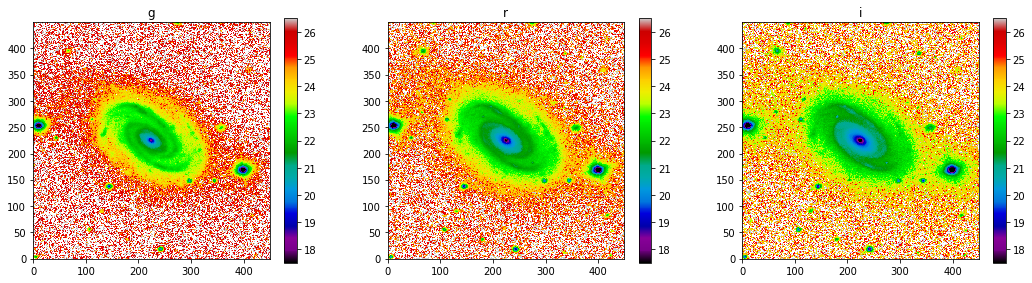

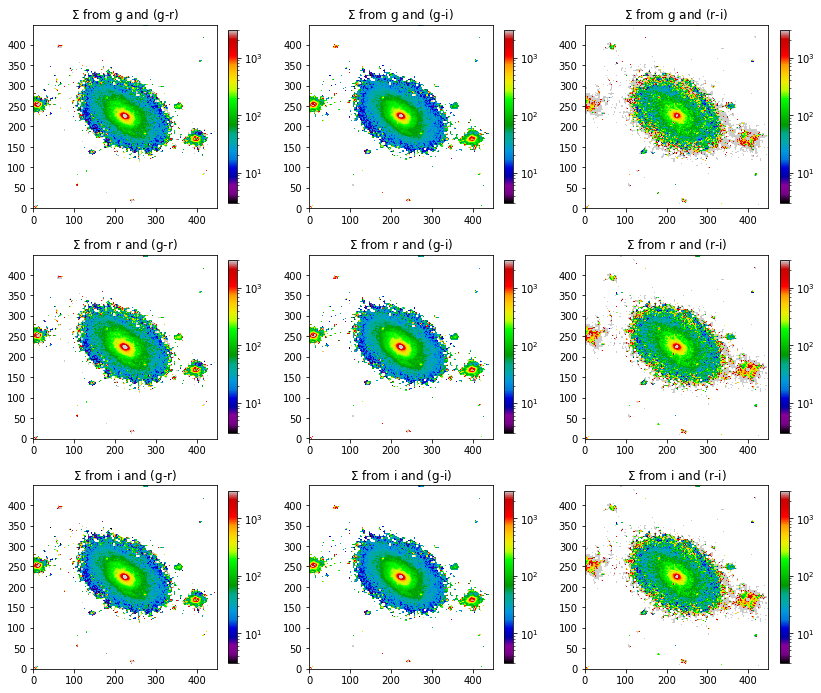

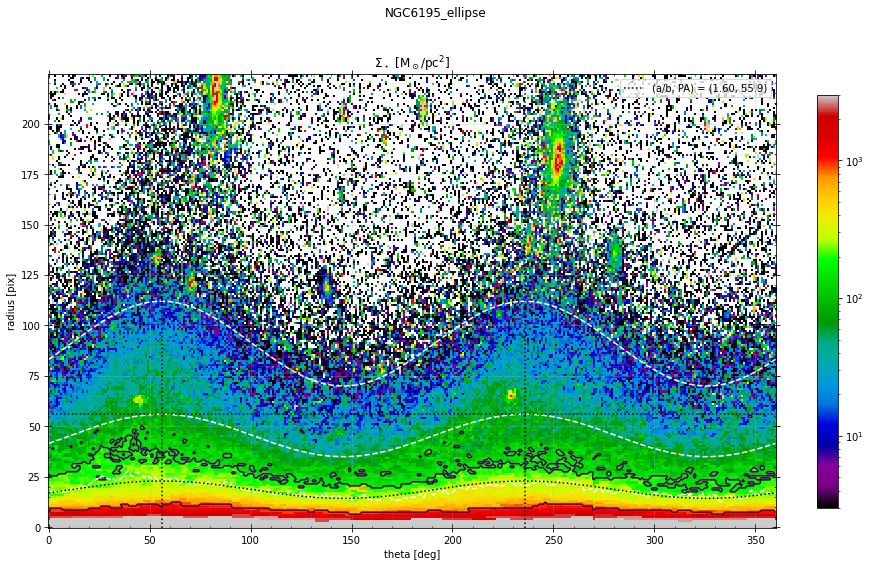

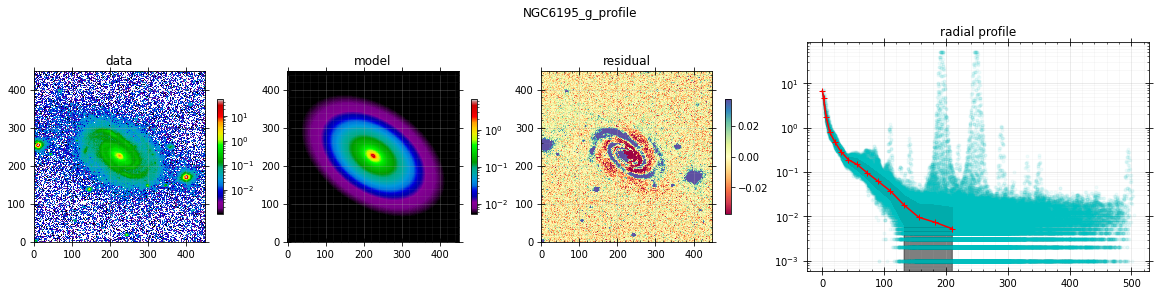

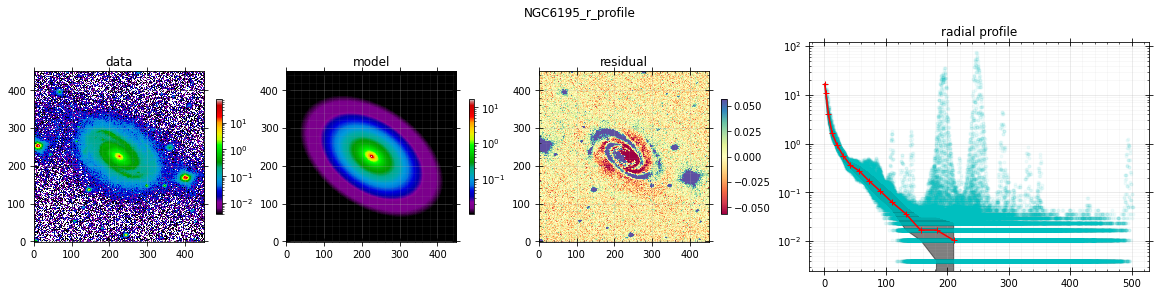

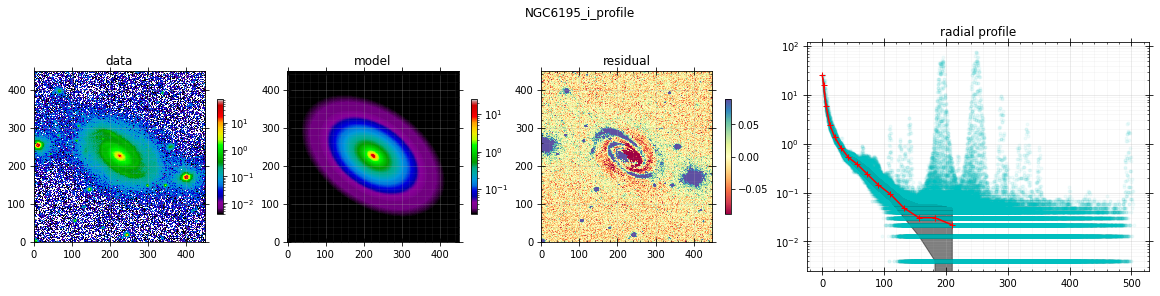

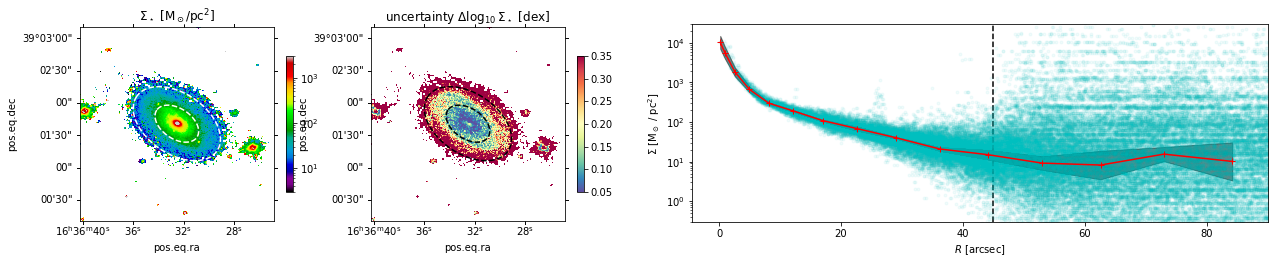

In [35]:
for galaxy in SPARC_catalogue:
    header, data = fectch_images(galaxy, SDSS_skymaps, fig_name=f"{galaxy['Galaxy']}_cutouts")
    surface_density_map, surface_density_err = estimate_stellar_surface_density(data, fig_name=f"{galaxy['Galaxy']}_mass-to-light")
    ellipse = Ellipse(surface_density_map, fig_name=f"{galaxy['Galaxy']}_ellipse")
    r_bins = {}
    median_profile = {}
    for band in data:
        r_bins[band], median_profile[band] = ellipse.get_profile(data[band], fig_name=f"{galaxy['Galaxy']}_{band}")[:2]
    surface_density_profile, surface_density_profile_err = estimate_stellar_surface_density(median_profile)
    
    #a = r_mid['g'][-1]
    #aper = EllipticalAperture((ellipse.x0, ellipse.y0), a, a/ellipse.axis_ratio, theta=np.pi/2 + ellipse.position_angle)
    
    hdr = header[next(iter(header))]
    hdr['BUNIT'] = 'M_sun / pc^2'
    hdr['COMMENT'] = 'M/L based on Garcia-Benito et al. (2019)'
    wcs = WCS(hdr)
    fits.PrimaryHDU(header=hdr, data=surface_density_map).writeto(
        os.path.join(maps_dir, f"{galaxy['Galaxy']}_surface_density.fits"), overwrite=True, output_verify='fix')
    
    # Median surface density and uncertainty

    fig = plt.figure(figsize=(20, 5))
    theta_disk = np.min(surface_density_map.shape) / 4

    ax = fig.add_subplot(141, projection=wcs)
    ax.set_title('$\Sigma_\star$ [M$_\odot$/pc$^2$]')
    im = ax.imshow(surface_density_map, origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(3, 3e3))
    ellipse.plot(ax, [.5*theta_disk, theta_disk], 'w--')
    cb = plt.colorbar(im, ax=ax, shrink=.5)
    
    ax = fig.add_subplot(142, projection=wcs)
    ax.set_title('uncertainty $\Delta\log_{10}\Sigma_\star$ [dex]')
    im = ax.imshow(surface_density_err, cmap='Spectral_r', vmin=.05, vmax=.35)
    #aper.plot(ax)
    ellipse.plot(ax, [.5*theta_disk, theta_disk], 'k--')
    cb = plt.colorbar(im, ax=ax, shrink=.5)
    
    ax = fig.add_subplot(143, position=[.55, .23, .4, .55])
    ax.set_ylabel(r'$\Sigma$ [M$_\odot$ / pc$^2$]')
    ax.set_xlabel(r'$R$ [arcsec]')
    ax.set_yscale('log')
    r_mid = r_bins['g']
    r_mid = (r_mid[1:] + r_mid[:-1]) / 2
    pixscale = wcs.proj_plane_pixel_scales()[0].to_value(u.arcsec)
    ax.axvline(theta_disk*pixscale, c='k', ls='--')
    ax.plot(ellipse.r_0.ravel()*pixscale, surface_density_map.ravel(), 'c.', alpha=.05)
    ax.plot(r_mid*pixscale, surface_density_profile, 'r-+')
    factor = 10**surface_density_profile_err
    ax.fill_between(r_mid*pixscale, surface_density_profile/factor, surface_density_profile*factor, color='k', alpha=.5)
    ax.set_ylim(.3, 3e4)
    ax.set_xlim(-.1*theta_disk*pixscale, 2*theta_disk*pixscale)
    
    fig.savefig(os.path.join(plots_dir, f"{galaxy['Galaxy']}_surface_density.png"), facecolor='white')